In [1774]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from fbprophet import Prophet
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (16,7)

In [1698]:
# loading xbox key metrics (likes, engagements, etc)
df = pd.read_excel("xbox_data_jul-dec.xls", sheet_name="Key Metrics")
df = df.iloc[1:].reset_index(drop=True)
df = df.set_index("Date")
daily = df[df.filter(like='Daily').columns]
#

# loading xbox gender and age data
gender_age = pd.read_excel("xbox_data_jul-dec.xls", sheet_name="Lifetime Likes by Gender and...")
gender_age = gender_age.drop("Description", axis=1)
date = gender_age['Date']
daily_female = gender_age[gender_age.filter(like="F").columns]
daily_female = daily_female.set_index(date).sum(axis=1).rename("Daily Female Fans")
# gender_age = gender_age.set_index("Date")
#

# loading xbox tagged data
tag = pd.read_csv("tags.csv")
tag['Tags'].fillna("",inplace=True)
tag['Tags'] = [tag.loc[i,'Tags'].split(",") for i in range(len(tag))]
l = list(tag['Tags'])
l = [[x.strip(' ') for x in p] for p in l]
tag['Tags'] = l
list_len = [len(i) for i in l]
longest = max(list_len)
cols = [f"Tag_{n}" for n in range(1,longest+1)]
tagged = pd.DataFrame(list(tag['Tags']), columns=cols)
#

# Exploratory

## Female

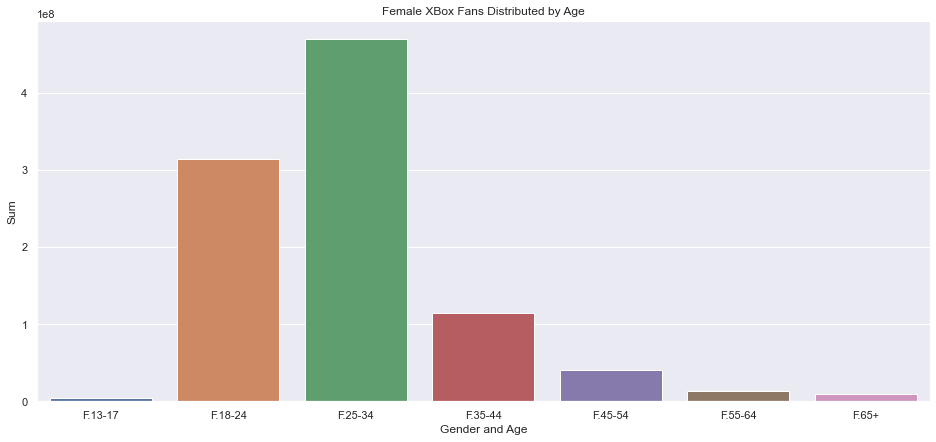

In [1699]:
# Preparing data for female audience
f = gender_age[gender_age.filter(like='F').columns]
#

# formatting ax
ax = sns.barplot(x=f.columns,y=f.sum())
ax.set_title("Female XBox Fans Distributed by Age")
ax.set_ylabel("Sum")
ax.set_xlabel("Gender and Age");
#

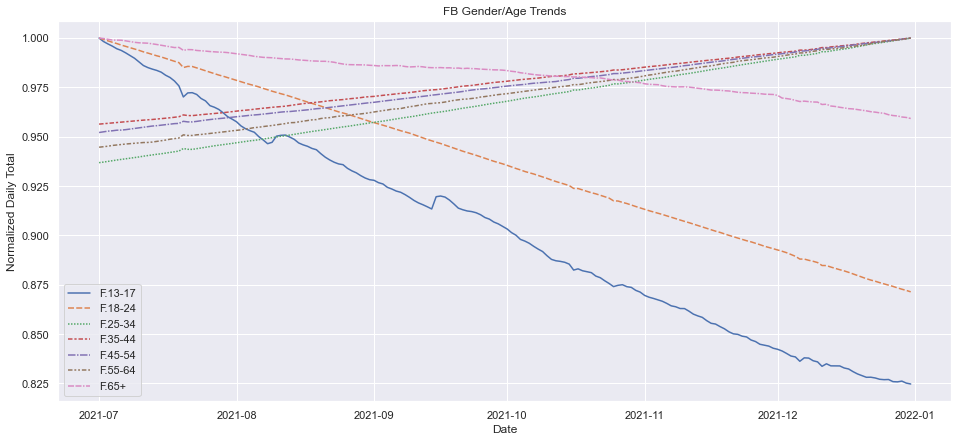

In [1700]:
# min-max normalizing female data to view all trends on same chart
normalized_f = (f-f.min())/(f.max()-f.min())
normalized_f.index = date
#

# removing outliers
z_scores = stats.zscore(normalized_f)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
normalized_f = normalized_f[filtered_entries]
#

# formatting ax
ax = sns.lineplot(data=normalized_f)
ax.set_title("FB Gender/Age Trends")
ax.set_ylabel("Normalized Daily Total")
ax.set_xlabel("Date");
#

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02001
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1760.73    0.00266348       63729.6           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1766.55   0.000150589       44580.1           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1770.46    0.00050312       43472.5           1           1      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1774.72   4.05099e-05       58139.3           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1776.27   7.29882e-05       25396.4           1           1      588   
    Iter      log prob        ||dx||      ||grad||       alpha  

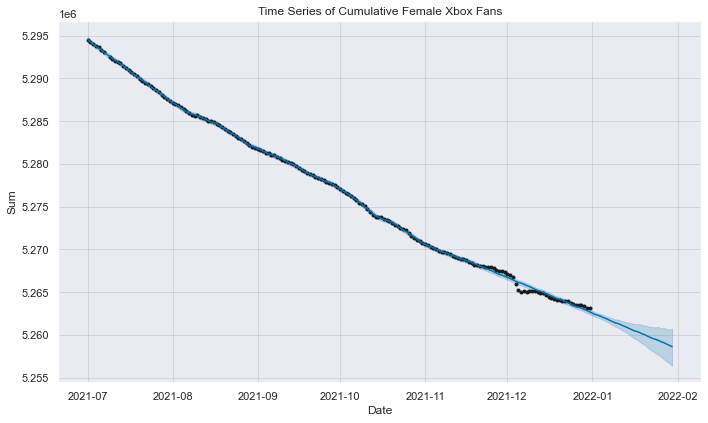

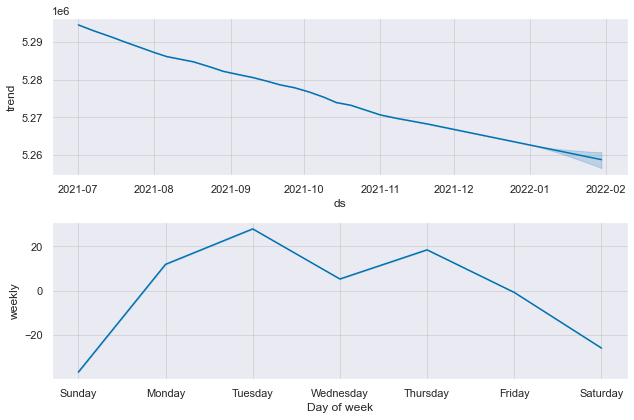

In [1701]:
# Preparing Time-Series Data
ds = date.rename("ds")
y = f.sum(axis=1).rename("y")
df = pd.concat([ds,y], axis=1)
#

# removing outliers
z_scores = stats.zscore(df.y)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
df = df[filtered_entries]
#

# FB Prophet TS
model = Prophet()
model.fit(df)
future = model.make_future_dataframe(freq="1D",periods=30)
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(forecast)
plt.title("Time Series of Cumulative Female Xbox Fans")
plt.ylabel("Sum")
plt.xlabel("Date")
plt.show()
model.plot_components(forecast)
plt.show();
#

In [1711]:
# dummy variables for tags
s = pd.Series(l)
tagged_dummies = pd.get_dummies(s.apply(pd.Series).stack()).groupby(level=0).sum()
tagged_dummies.index = tag['Date'].apply(lambda x: pd.to_datetime(x))
rs_tagged_dummies = tagged_dummies.resample("1D").sum()
rs_tagged_dummies.insert(0, "Daily New Likes", daily['Daily New Likes'])
rs_tagged_dummies = rs_tagged_dummies.drop([""], axis=1)
#

# splitting training and testing data
np.random.seed(0) # specifying the random seed so that the results are replicable
df_train, df_test = train_test_split(rs_tagged_dummies, train_size=0.9, test_size=0.1, random_state=100)
#

# X_Train, y_train
y_train = df_train.pop('Daily New Likes')
X_train = df_train

In [1712]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train.astype(float))
rfe = RFE(lm)             # running RFE
rfe = rfe.fit(X_train, y_train)
#

# using the cols selected by RFE to run the regression
rfe_results = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
cols = [x[0] for x in rfe_results if x[2]<=2]
X_train_rfe = X_train[cols]
X_train_rfe = sm.add_constant(X_train_rfe)

# Running the linear model
lm = sm.OLS(y_train.astype(float),X_train_rfe).fit()
print(lm.summary())
#

                            OLS Regression Results                            
Dep. Variable:        Daily New Likes   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     3.207
Date:                Mon, 21 Feb 2022   Prob (F-statistic):           2.24e-06
Time:                        18:06:45   Log-Likelihood:                -1193.4
No. Observations:                 165   AIC:                             2449.
Df Residuals:                     134   BIC:                             2545.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

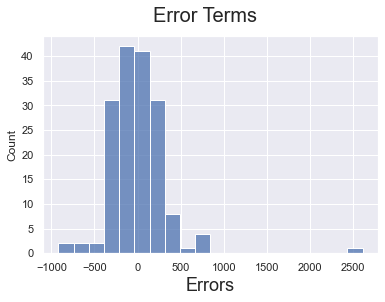

In [1713]:
y_train_followers = lm.predict(X_train_rfe)

# Plot the histogram of the error terms
fig = plt.figure(figsize=(6,4))
sns.histplot((y_train - y_train_followers), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18);                        # X-label

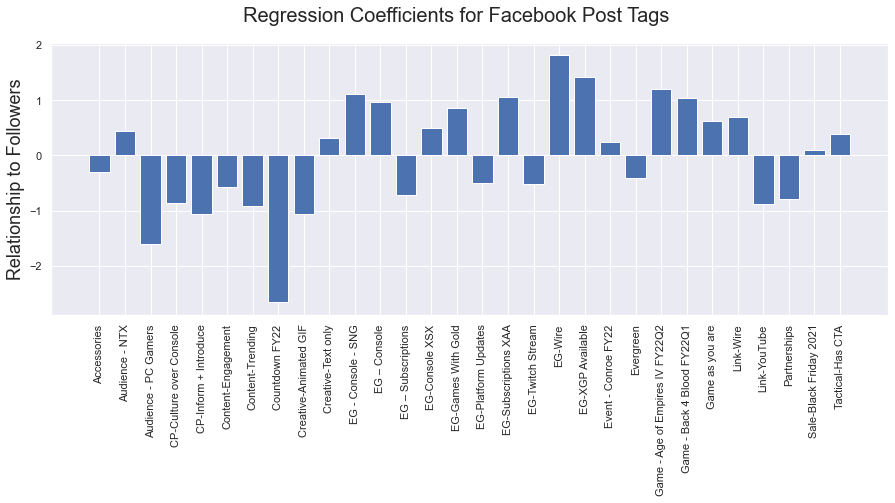

In [1714]:
scaler = StandardScaler()
scaled = scaler.fit_transform([[x] for x in lm.params[1:]])
scaled = [x for lst in scaled for x in lst]

fig = plt.figure(figsize=(15, 5))
plt.bar(x=lm.params[1:].index,height=scaled)
plt.xticks(rotation=90)
fig.suptitle('Regression Coefficients for Facebook Post Tags', fontsize=20)
plt.ylabel("Relationship to Followers", fontsize=18);                  # Plot heading

In [1715]:
lm.params.rename("coef").to_excel("output.xlsx", sheet_name=sheet)

In [1716]:
sheet = "facebook"

lm.params.rename("coef").to_excel("output.xlsx", sheet_name=sheet)

with pd.ExcelWriter('output.xlsx',
                    mode='a',if_sheet_exists='replace') as writer:  
    pd.DataFrame(scaled, index=lm.params.index[1:], columns=["coef"]).to_excel(writer, sheet_name=f"{sheet} scaled")

# Fan Growth

## Overall Fan Growth With and Without Facebook

In [1717]:
# Loading in Social Media Fans Benchmark
b = pd.read_excel("Benchmark.xlsx", sheet_name="Daily", skiprows=1)
ind1 = b[~pd.isna(b["Total FB Fans"])][0:1].index[0]
ind2 = b[~pd.isna(b["Total FB Fans"])][-1:].index[0]
b = b.loc[ind1:ind2].reset_index(drop=True)
total_fans = b.loc[:,"Dates":"Total TT Fans"]
#

In [1718]:
# Parsing all data to have the same number of data points
ind1 = total_fans[~pd.isna(total_fans['Total Snapchat'])][0:1].index[0]
ind2 = total_fans[~pd.isna(total_fans['Total Snapchat'])][-1:].index[0]
sc_tt = total_fans.loc[ind1:ind2].reset_index(drop=True)
#

# Removing dates from the DF for further analysis
dates = sc_tt.pop("Dates")
#

# Interpolating missing values with spline curve fitting, with an order of 1
b2 = sc_tt.interpolate(method='spline', order=1).round()
b2['Overall no FB'] = b2.loc[:,(b2.columns!="Total FB Fans")&(b2.columns!="Date")].sum(axis=1)
b2['Overall w FB'] = b2.loc[:,(b2.columns!="Date")&(b2.columns!="Overall no FB")].sum(axis=1)
#

# b2['Norm no FB']=(b2['Overall no FB']-b2['Overall no FB'].min())/(b2['Overall no FB'].max()-b2['Overall no FB'].min())
# b2['Norm w FB']=(b2['Overall w FB']-b2['Overall w FB'].min())/(b2['Overall w FB'].max()-b2['Overall w FB'].min())

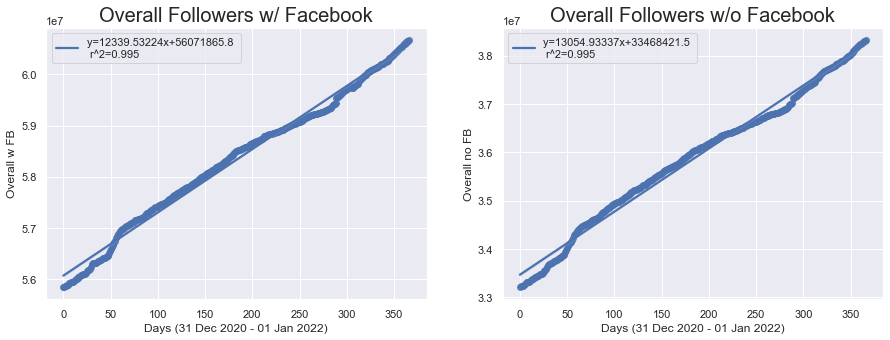

In [1719]:
# Setting up the figure and axes
f, axes = plt.subplots(1, 2, figsize=(15,5))
#

# Fig 1 - with Facebook
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(b2.index,b2["Overall w FB"])
sns.regplot(x=b2.index, y=b2["Overall w FB"], data=b2, color='b', 
 line_kws={'label':"y={0:.5f}x+{1:.1f} \n r^2={2:.3f}".format(slope1,intercept1,r_value1)}, ax=axes[0])
axes[0].legend(loc="best")
axes[0].set_title("Overall Followers w/ Facebook",fontsize=20)
axes[0].set_xlabel("Days (31 Dec 2020 - 01 Jan 2022)")
#

# Fig 2 - without Facebook
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(b2.index,b2["Overall no FB"])
sns.regplot(x=b2.index, y=b2["Overall no FB"], data=b2, color='b', 
 line_kws={'label':"y={0:.5f}x+{1:.1f} \n r^2={2:.3f}".format(slope2,intercept2,r_value2)}, ax=axes[1])
axes[1].legend(loc="best")
axes[1].set_title("Overall Followers w/o Facebook",fontsize=20)
axes[1].set_xlabel("Days (31 Dec 2020 - 01 Jan 2022)")
#

plt.show()

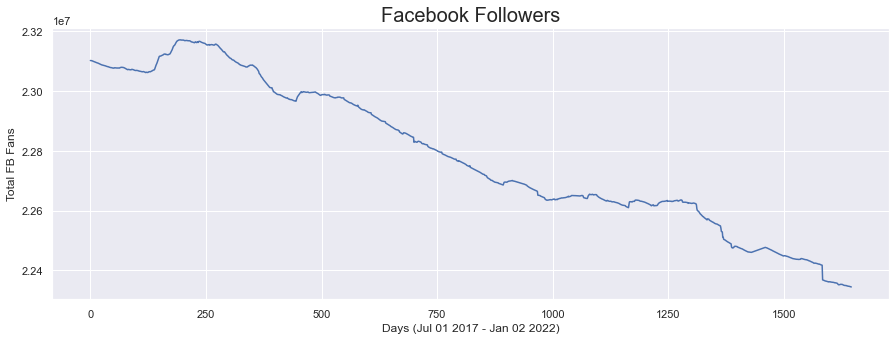

In [1720]:
# Fig 3 - Facebook Followers Trend
fig = plt.figure(figsize=(15, 5))
ax = sns.lineplot(data=b, x=b.index, y=b['Total FB Fans'])
ax.set_title("Facebook Followers",fontsize=20)
ax.set_xlabel("Days (Jul 01 2017 - Jan 02 2022)")
#

plt.show()

# Growth within Key Audiences by Channel

In [1757]:
fb_dem = pd.read_excel("demographics.xlsx", sheet_name="Facebook")
tt_dem = pd.read_excel("demographics.xlsx", sheet_name="TikTok")
sc_dem = pd.read_excel("demographics.xlsx", sheet_name="Snapchat")
ig_dem = pd.read_excel("demographics.xlsx", sheet_name="Instagram")
yt_dem = pd.read_excel("demographics.xlsx", sheet_name="YouTube")

## Facebook

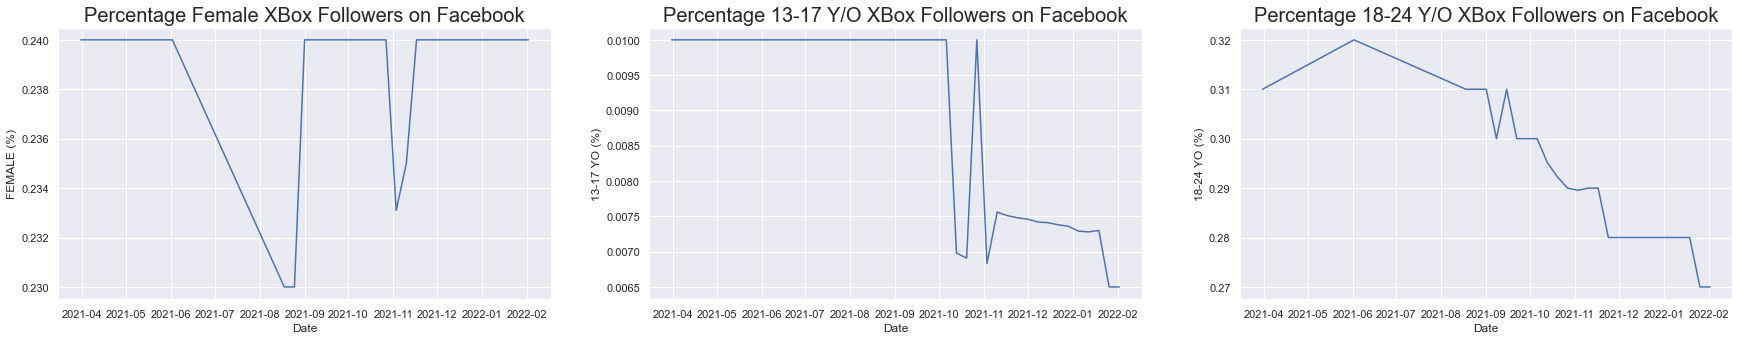

In [1814]:
plat = "Facebook"

# Setting up the figure and axes
f, axes = plt.subplots(1, 3, figsize=(30,5))
#

data = fb_dem
x = data["WEEK ENDING"]
y = data["FEMALE (%)"]

# Fig 1 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[0])
axes[0].set_title(f"Percentage Female XBox Followers on {plat}",fontsize=20)
axes[0].set_xlabel("Date");
#

x = data["WEEK ENDING"]
y = data["13-17 YO (%)"]

# Fig 2 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[1])
axes[1].set_title(f"Percentage 13-17 Y/O XBox Followers on {plat}",fontsize=20)
axes[1].set_xlabel("Date");
#

x = data["WEEK ENDING"]
y = data["18-24 YO (%)"]

# Fig 2 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[2])
axes[2].set_title(f"Percentage 18-24 Y/O XBox Followers on {plat}",fontsize=20)
axes[2].set_xlabel("Date");
#

## TikTok

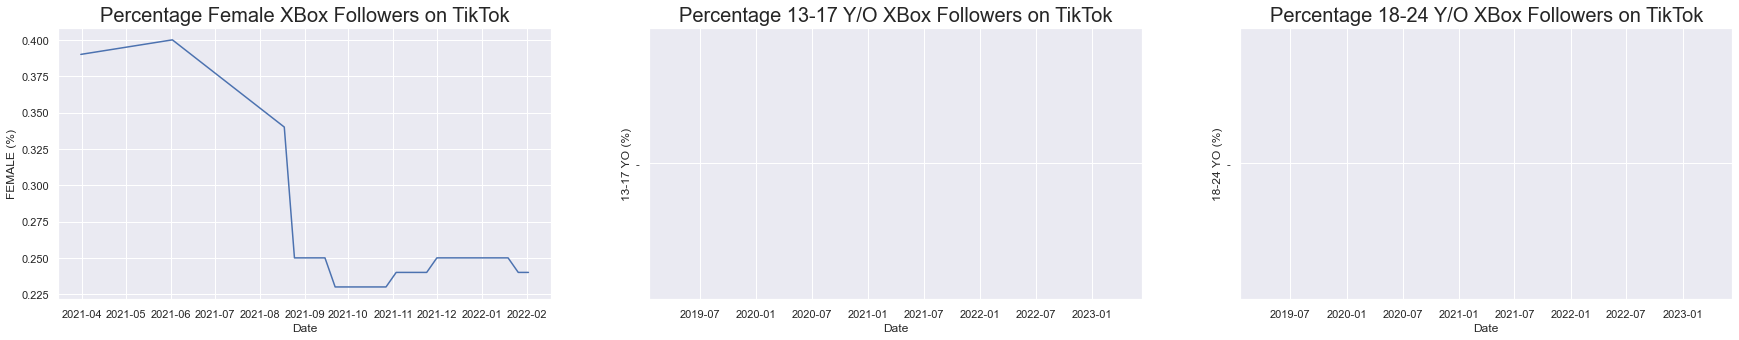

In [1817]:
plat = "TikTok"

# Setting up the figure and axes
f, axes = plt.subplots(1, 3, figsize=(30,5))
#

data = tt_dem
x = data["WEEK ENDING"]
y = data["FEMALE (%)"]

# Fig 1 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[0])
axes[0].set_title(f"Percentage Female XBox Followers on {plat}",fontsize=20)
axes[0].set_xlabel("Date");
#

x = data["WEEK ENDING"]
y = data["13-17 YO (%)"]

# Fig 2 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[1])
axes[1].set_title(f"Percentage 13-17 Y/O XBox Followers on {plat}",fontsize=20)
axes[1].set_xlabel("Date");
#

x = data["WEEK ENDING"]
y = data["18-24 YO (%)"]

# Fig 2 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[2])
axes[2].set_title(f"Percentage 18-24 Y/O XBox Followers on {plat}",fontsize=20)
axes[2].set_xlabel("Date");
#

## Snapchat

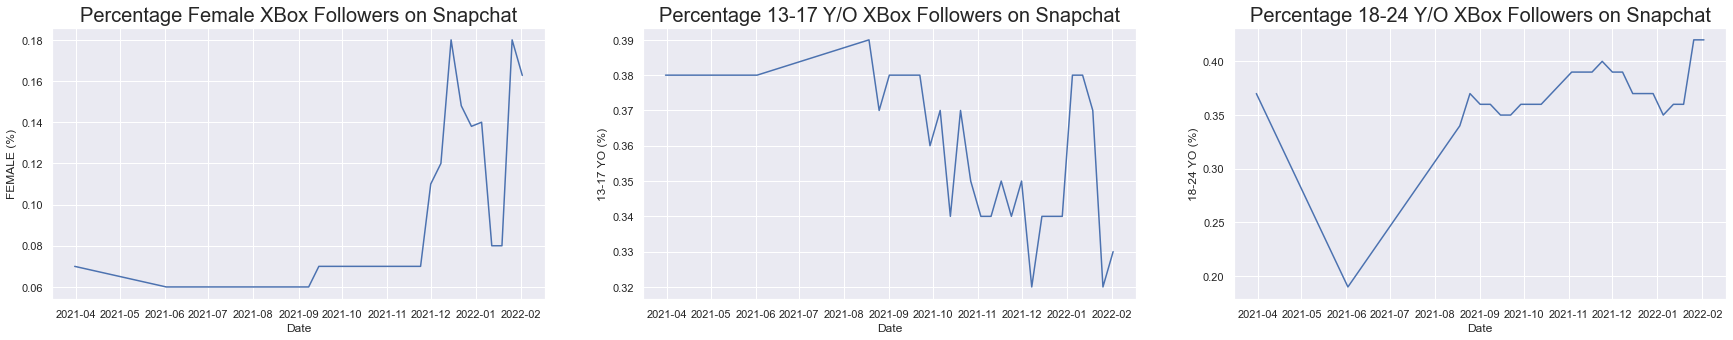

In [1818]:
plat = "Snapchat"

# Setting up the figure and axes
f, axes = plt.subplots(1, 3, figsize=(30,5))
#

data = sc_dem
x = data["WEEK ENDING"]
y = data["FEMALE (%)"]

# Fig 1 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[0])
axes[0].set_title(f"Percentage Female XBox Followers on {plat}",fontsize=20)
axes[0].set_xlabel("Date");
#

x = data["WEEK ENDING"]
y = data["13-17 YO (%)"]

# Fig 2 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[1])
axes[1].set_title(f"Percentage 13-17 Y/O XBox Followers on {plat}",fontsize=20)
axes[1].set_xlabel("Date");
#

x = data["WEEK ENDING"]
y = data["18-24 YO (%)"]

# Fig 2 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[2])
axes[2].set_title(f"Percentage 18-24 Y/O XBox Followers on {plat}",fontsize=20)
axes[2].set_xlabel("Date");
#

## Instagram

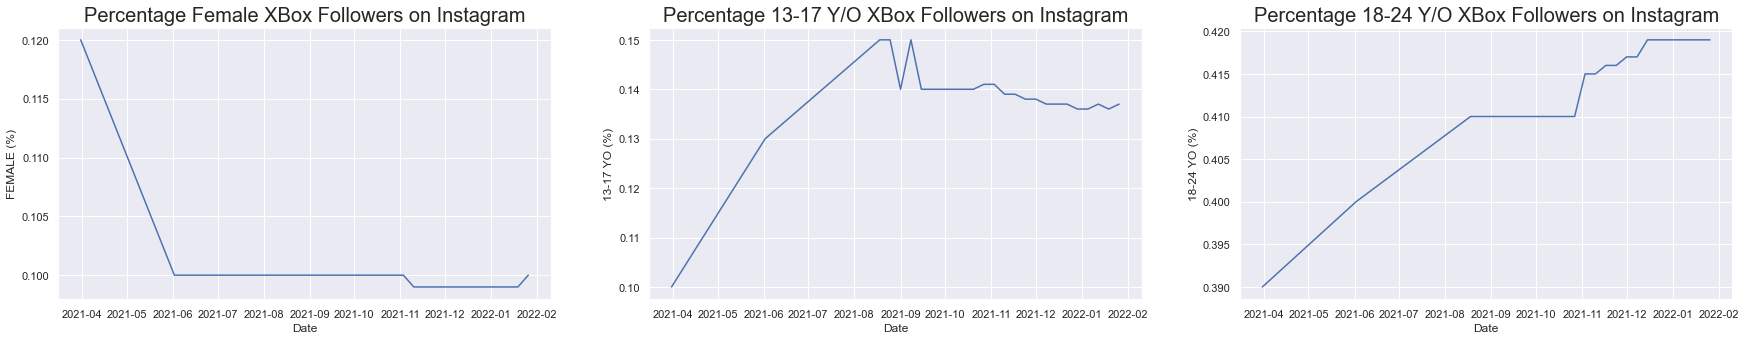

In [1819]:
plat = "Instagram"

# Setting up the figure and axes
f, axes = plt.subplots(1, 3, figsize=(30,5))
#

data = ig_dem
x = data["WEEK ENDING"]
y = data["FEMALE (%)"]

# Fig 1 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[0])
axes[0].set_title(f"Percentage Female XBox Followers on {plat}",fontsize=20)
axes[0].set_xlabel("Date");
#

x = data["WEEK ENDING"]
y = data["13-17 YO (%)"]

# Fig 2 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[1])
axes[1].set_title(f"Percentage 13-17 Y/O XBox Followers on {plat}",fontsize=20)
axes[1].set_xlabel("Date");
#

x = data["WEEK ENDING"]
y = data["18-24 YO (%)"]

# Fig 2 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[2])
axes[2].set_title(f"Percentage 18-24 Y/O XBox Followers on {plat}",fontsize=20)
axes[2].set_xlabel("Date");
#

## YouTube

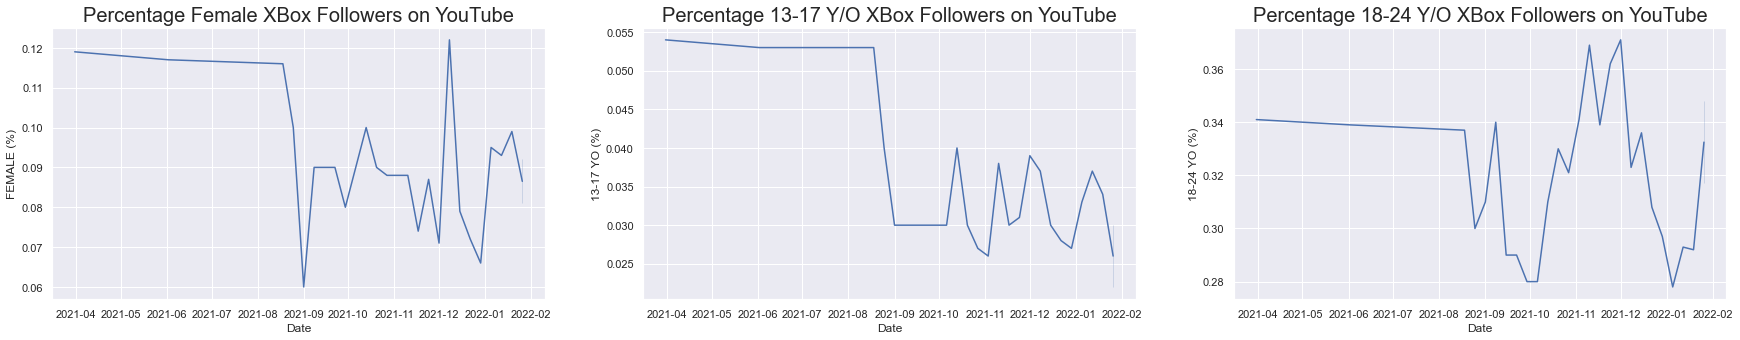

In [1820]:
plat = "YouTube"

# Setting up the figure and axes
f, axes = plt.subplots(1, 3, figsize=(30,5))
#

data = yt_dem
x = data["WEEK ENDING"]
y = data["FEMALE (%)"]

# Fig 1 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[0])
axes[0].set_title(f"Percentage Female XBox Followers on {plat}",fontsize=20)
axes[0].set_xlabel("Date");
#

x = data["WEEK ENDING"]
y = data["13-17 YO (%)"]

# Fig 2 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[1])
axes[1].set_title(f"Percentage 13-17 Y/O XBox Followers on {plat}",fontsize=20)
axes[1].set_xlabel("Date");
#

x = data["WEEK ENDING"]
y = data["18-24 YO (%)"]

# Fig 2 - female xbox followers on fb
sns.lineplot(data=data, x=x, y=y, ax=axes[2])
axes[2].set_title(f"Percentage 18-24 Y/O XBox Followers on {plat}",fontsize=20)
axes[2].set_xlabel("Date");
#

# Regressions by Post Tags, by Channel, by Audience

In [1721]:
TT = pd.read_excel("social.xlsx", sheet_name="TikTok ")
tt = TT[~pd.isna(TT['Audience'])]

SC = pd.read_excel("social.xlsx", sheet_name="Snapchat")
sc = SC[(SC['Audience']!='\xa0')]

IG = pd.read_excel("social.xlsx", sheet_name="IG Reels")
igr = IG[~pd.isna(IG['Audience'])]

IG = pd.read_excel("social.xlsx", sheet_name="IG Stories")
igs = IG[~pd.isna(IG['Audience'])]

## TikTok

In [1722]:
# cleaning TT data
tt_tags = tt.iloc[:,-10:]
tt_tags[['Audience1', 'Audience2']] = tt_tags['Audience'].str.split(",", expand=True)
tt_tags = tt_tags.drop("Audience", axis=1)
tt_tags = pd.get_dummies(tt_tags)
tt_tags.index = tt['Date']
rs_tagged_dummies = tt_tags.resample("1D").sum()
tt_fans = b[b['Dates'].isin(list(rs_tagged_dummies.index.date))].set_index("Dates")['Total TT Fans']
rs_tagged_dummies.insert(0, "TikTok Fans", tt_fans)
#

# splitting training and testing data
np.random.seed(0) # specifying the random seed so that the results are replicable
df_train, df_test = train_test_split(rs_tagged_dummies, train_size=0.9, test_size=0.1, random_state=100)
#

# X_Train, y_train
y_train = df_train.pop('TikTok Fans')
X_train = df_train

In [1723]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             # running RFE
rfe = rfe.fit(X_train, y_train)
#

# using the cols selected by RFE to run the regression
rfe_results = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
cols = [x[0] for x in rfe_results if x[2]<=2]
cols.remove("Titles_Has CTA")
X_train_rfe = X_train[cols]
X_train_rfe = sm.add_constant(X_train_rfe)

# Running the linear model
lm = sm.OLS(y_train.astype(float),X_train_rfe).fit()
print(lm.summary())
#

                            OLS Regression Results                            
Dep. Variable:            TikTok Fans   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     4.267
Date:                Mon, 21 Feb 2022   Prob (F-statistic):           5.43e-07
Time:                        18:09:46   Log-Likelihood:                -2209.8
No. Observations:                 163   AIC:                             4456.
Df Residuals:                     145   BIC:                             4511.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


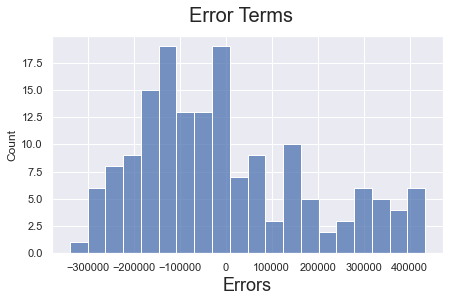

In [1724]:
y_train_followers = lm.predict(X_train_rfe)

# Plot the histogram of the error terms
fig = plt.figure(figsize=(7,4))
sns.histplot((y_train - y_train_followers), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18);                        # X-label

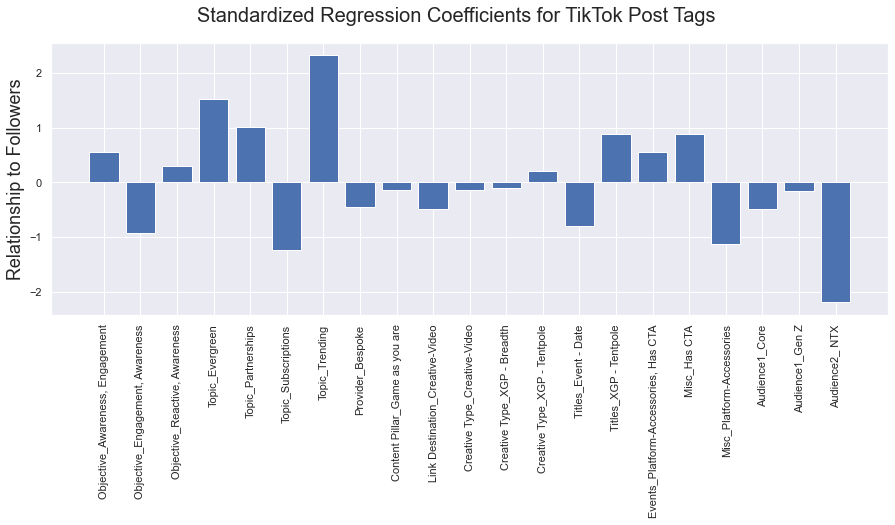

In [1725]:
scaler = StandardScaler()
scaled = scaler.fit_transform([[x] for x in lm.params[1:]])
scaled = [x for lst in scaled for x in lst]

fig = plt.figure(figsize=(15, 5))
plt.bar(x=lm.params[1:].index,height=scaled)
plt.xticks(rotation=90)
fig.suptitle('Standardized Regression Coefficients for TikTok Post Tags', fontsize=20)
plt.ylabel("Relationship to Followers", fontsize=18);                  # Plot heading

In [1726]:
sheet = "tiktok"
with pd.ExcelWriter('output.xlsx',
                    mode='a',if_sheet_exists='replace') as writer:  
    lm.params.rename("coef").to_excel(writer, sheet_name=sheet)
    pd.DataFrame(scaled, index=lm.params.index[1:], columns=["coef"]).to_excel(writer, sheet_name=f"{sheet} scaled")

## Snapchat

note: several values were missing for snapchat follower data. I interpolated the data using an order 1 spline.

In [1727]:
b3 = b2.set_index(dates)

sc_tags = sc.iloc[:,-10:]
sc_tags[['Audience1', 'Audience2']] = sc_tags['Audience'].str.split(",", expand=True)
sc_tags = sc_tags.drop("Audience", axis=1)
sc_tags = pd.get_dummies(sc_tags)
sc_tags.index = sc['Day']
rs_tagged_dummies = sc_tags.resample("1D").sum()
sc_fans = b3[b3.index.isin(list(rs_tagged_dummies.index.date))]['Total Snapchat']
rs_tagged_dummies.insert(0, "Snapchat Fans", sc_fans)

y = rs_tagged_dummies.pop("Snapchat Fans")
X = rs_tagged_dummies

In [1728]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X, y)
rfe = RFE(lm)             # running RFE
rfe = rfe.fit(X, y)
#

# using the cols selected by RFE to run the regression
rfe_results = list(zip(X.columns,rfe.support_,rfe.ranking_))
cols = [x[0] for x in rfe_results if x[2]<=2]
cols.remove("Titles_Has CTA")
X_rfe = X[cols]
X_rfe = sm.add_constant(X_rfe)

# Running the linear model
lm = sm.OLS(y.astype(float),X_rfe).fit()
print(lm.summary())
#

                            OLS Regression Results                            
Dep. Variable:          Snapchat Fans   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     1.648
Date:                Mon, 21 Feb 2022   Prob (F-statistic):             0.0316
Time:                        18:10:07   Log-Likelihood:                -3196.3
No. Observations:                 295   AIC:                             6443.
Df Residuals:                     270   BIC:                             6535.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

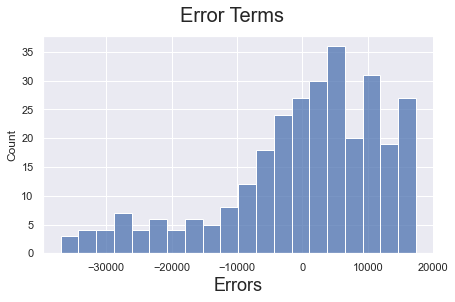

In [1729]:
y_followers = lm.predict(X_rfe)

# Plot the histogram of the error terms
fig = plt.figure(figsize=(7,4))
sns.histplot((y - y_followers), bins=20)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('Errors', fontsize=18);                        # X-label

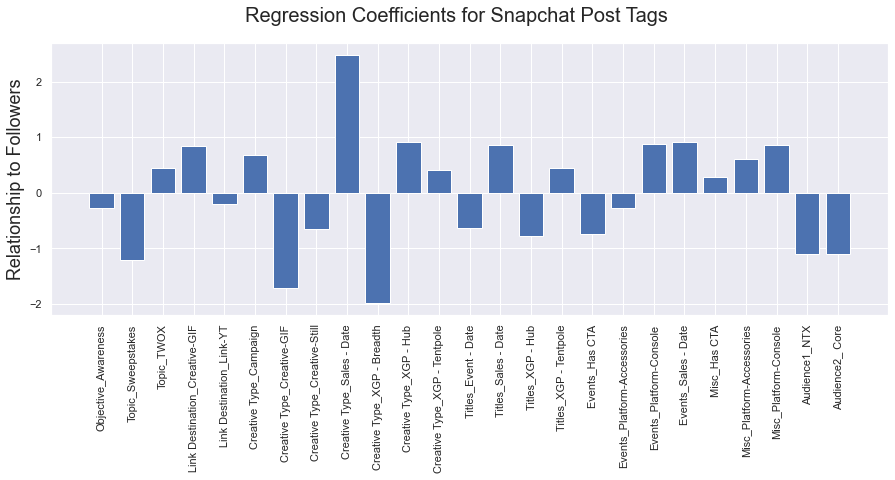

In [1730]:
scaler = StandardScaler()
scaled = scaler.fit_transform([[x] for x in lm.params[1:]])
scaled = [x for lst in scaled for x in lst]

fig = plt.figure(figsize=(15, 5))
plt.bar(x=lm.params[1:].index,height=scaled)
plt.xticks(rotation=90)
fig.suptitle('Regression Coefficients for Snapchat Post Tags', fontsize=20)
plt.ylabel("Relationship to Followers", fontsize=18);                  # Plot heading

In [1731]:
sheet = "snapchat"
with pd.ExcelWriter('output.xlsx',
                    mode='a',if_sheet_exists='replace') as writer:  
    lm.params.rename("coef").to_excel(writer, sheet_name=sheet)
    pd.DataFrame(scaled, index=lm.params.index[1:], columns=["coef"]).to_excel(writer, sheet_name=f"{sheet} scaled")

## Instagram (Stories, Feed, Reels)

### Reels

In [1732]:
igr_tags = igr.iloc[:,-10:]
igr_tags[['Audience1', 'Audience2']] = igr_tags['Audience'].str.split(",", expand=True)
igr_tags = igr_tags.drop("Audience", axis=1)
igr_tags = pd.get_dummies(igr_tags)
igr_tags.index = igr['Date']
rs_tagged_dummies = igr_tags.resample("1D").sum()
igr_fans = b3[b3.index.isin(list(rs_tagged_dummies.index.date))]['Total IG Fans']
rs_tagged_dummies.insert(0, "IG Fans", igr_fans)

y = rs_tagged_dummies.pop("IG Fans")
X = rs_tagged_dummies

In [1733]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X, y)
rfe = RFE(lm)             # running RFE
rfe = rfe.fit(X, y)
#

# using the cols selected by RFE to run the regression
rfe_results = list(zip(X.columns,rfe.support_,rfe.ranking_))
cols = [x[0] for x in rfe_results if x[2]<=2]
#cols.remove("Titles_Has CTA")
X_rfe = X[cols]
X_rfe = sm.add_constant(X_rfe)

# Running the linear model
lm = sm.OLS(y.astype(float),X_rfe).fit()
print(lm.summary())
#

                            OLS Regression Results                            
Dep. Variable:                IG Fans   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.668
Date:                Mon, 21 Feb 2022   Prob (F-statistic):           2.00e-05
Time:                        18:10:10   Log-Likelihood:                -4481.3
No. Observations:                 339   AIC:                             8981.
Df Residuals:                     330   BIC:                             9015.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
co

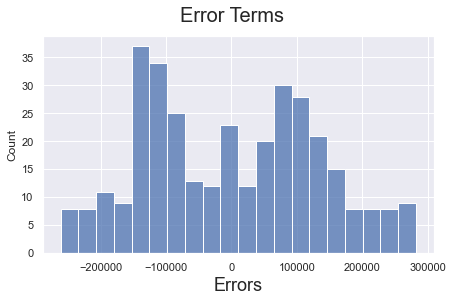

In [1734]:
y_followers = lm.predict(X_rfe)

# Plot the histogram of the error terms
fig = plt.figure(figsize=(7,4))
sns.histplot((y - y_followers), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18);                        # X-label

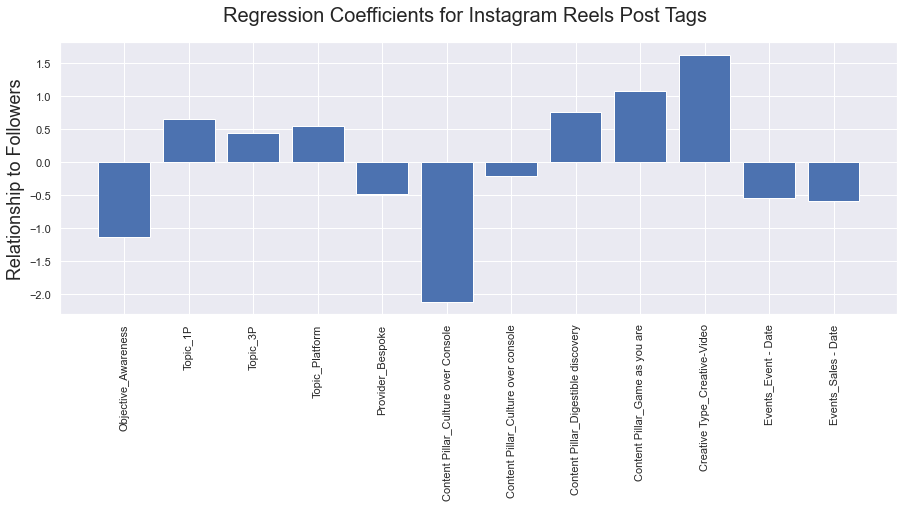

In [1735]:
scaler = StandardScaler()
scaled = scaler.fit_transform([[x] for x in lm.params[1:]])
scaled = [x for lst in scaled for x in lst]

fig = plt.figure(figsize=(15, 5))
plt.bar(x=lm.params[1:].index,height=scaled)
plt.xticks(rotation=90)
fig.suptitle('Regression Coefficients for Instagram Reels Post Tags', fontsize=20)
plt.ylabel("Relationship to Followers", fontsize=18);                  # Plot heading

In [1736]:
sheet = "ig reels"
with pd.ExcelWriter('output.xlsx',
                    mode='a',if_sheet_exists='replace') as writer:  
    lm.params.rename("coef").to_excel(writer, sheet_name=sheet)
    pd.DataFrame(scaled, index=lm.params.index[1:], columns=["coef"]).to_excel(writer, sheet_name=f"{sheet} scaled")

### Stories

In [1737]:
igs_tags = igs.iloc[:,-10:]
igs_tags[['Audience1', 'Audience2']] = igs_tags['Audience'].str.split(",", expand=True)
igs_tags = igs_tags.drop("Audience", axis=1)
igs_tags = pd.get_dummies(igs_tags)
igs_tags.index = igs['Date']
rs_tagged_dummies = igs_tags.resample("1D").sum()
igs_fans = b3[b3.index.isin(list(rs_tagged_dummies.index.date))]['Total IG Fans']
rs_tagged_dummies.insert(0, "IG Fans", igs_fans)

y = rs_tagged_dummies.pop("IG Fans")
X = rs_tagged_dummies

In [1738]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X, y)
rfe = RFE(lm)             # running RFE
rfe = rfe.fit(X, y)
#

# using the cols selected by RFE to run the regression
rfe_results = list(zip(X.columns,rfe.support_,rfe.ranking_))
cols = [x[0] for x in rfe_results if x[2]<=2]
#cols.remove("Titles_Has CTA")
X_rfe = X[cols]
X_rfe = sm.add_constant(X_rfe)

# Running the linear model
lm = sm.OLS(y.astype(float),X_rfe).fit()
print(lm.summary())
#

                            OLS Regression Results                            
Dep. Variable:                IG Fans   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     5.826
Date:                Mon, 21 Feb 2022   Prob (F-statistic):           2.82e-11
Time:                        18:10:14   Log-Likelihood:                -2260.6
No. Observations:                 183   AIC:                             4563.
Df Residuals:                     162   BIC:                             4631.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1.235e+

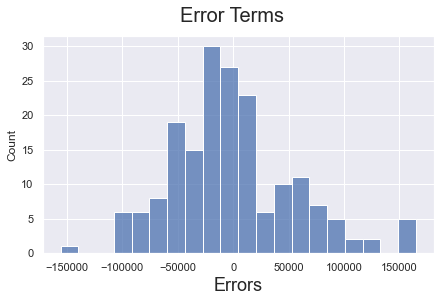

In [1739]:
y_followers = lm.predict(X_rfe)

# Plot the histogram of the error terms
fig = plt.figure(figsize=(7,4))
sns.histplot((y - y_followers), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18);                        # X-label

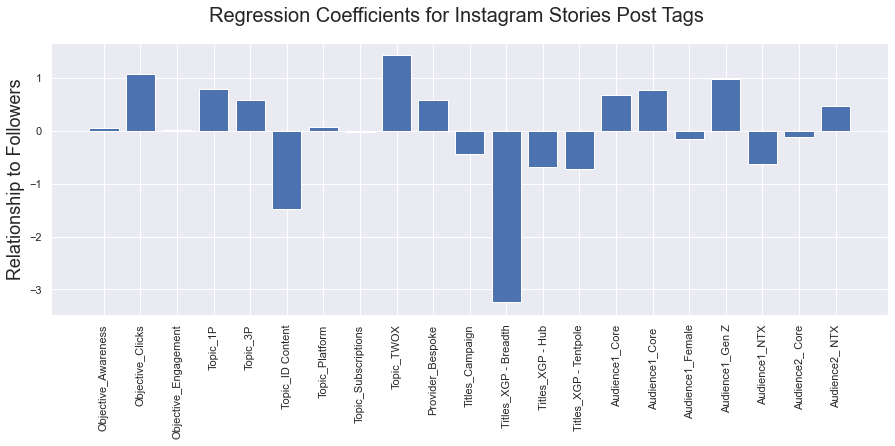

In [1740]:
scaler = StandardScaler()
scaled = scaler.fit_transform([[x] for x in lm.params[1:]])
scaled = [x for lst in scaled for x in lst]

fig = plt.figure(figsize=(15, 5))
plt.bar(x=lm.params[1:].index,height=scaled)
plt.xticks(rotation=90)
fig.suptitle('Regression Coefficients for Instagram Stories Post Tags', fontsize=20)
plt.ylabel("Relationship to Followers", fontsize=18);                  # Plot heading

In [1741]:
sheet = "ig stories"
with pd.ExcelWriter('output.xlsx',
                    mode='a',if_sheet_exists='replace') as writer:  
    lm.params.rename("coef").to_excel(writer, sheet_name=sheet)
    pd.DataFrame(scaled, index=lm.params.index[1:], columns=["coef"]).to_excel(writer, sheet_name=f"{sheet} scaled")

## YouTube

In [1742]:
YT = pd.read_csv("YT.csv")
yt_tags = YT['Tags']
# yt_tags.index = YT['Date'].apply(lambda x: pd.to_datetime(x, format="%m/%d/%Y %I:%M %p", errors="ignore"))
yt_tags.fillna("",inplace=True)
tags = [yt_tags[i].split(",") for i in range(len(yt_tags))]
l = list(tags)
l = [[x.strip(' ') for x in p] for p in l]
list_len = [len(i) for i in l]
longest = max(list_len)
cols = [f"Tag_{n}" for n in range(1,longest+1)]
tagged = pd.DataFrame(list(tags), columns=cols)

In [1743]:
s = pd.Series(l)
tagged_dummies = pd.get_dummies(s.apply(pd.Series).stack()).groupby(level=0).sum()
tagged_dummies.index = yt_tags.index
new_followers = (YT["Subscribers Gained from Video"].str.replace(',', '').astype(float) -
                 YT["Subscribers Lost from Video"].astype(float))
tagged_dummies.insert(0, "YT Fans", new_followers)
tagged_dummies.index = YT['Date'].apply(lambda x: pd.to_datetime(x, format="%m/%d/%Y %I:%M %p", errors="ignore"))
rs_tagged_dummies = tagged_dummies.resample("1D").sum()
rs_tagged_dummies = rs_tagged_dummies.drop([""], axis=1)

# X_Train, y_train
y = rs_tagged_dummies.pop('YT Fans')
X = rs_tagged_dummies

In [1744]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X, y.astype(float))
rfe = RFE(lm)             # running RFE
rfe = rfe.fit(X_train, y_train)
#

# using the cols selected by RFE to run the regression
rfe_results = list(zip(X.columns,rfe.support_,rfe.ranking_))
cols = [x[0] for x in rfe_results if x[2]<=2]
X_rfe = X[cols]
X_rfe = sm.add_constant(X_rfe)

# Running the linear model
lm = sm.OLS(y.astype(float),X_rfe).fit()
print(lm.summary())
#

                            OLS Regression Results                            
Dep. Variable:                YT Fans   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     4.703
Date:                Mon, 21 Feb 2022   Prob (F-statistic):           2.79e-09
Time:                        18:10:25   Log-Likelihood:                -1632.8
No. Observations:                 184   AIC:                             3312.
Df Residuals:                     161   BIC:                             3385.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

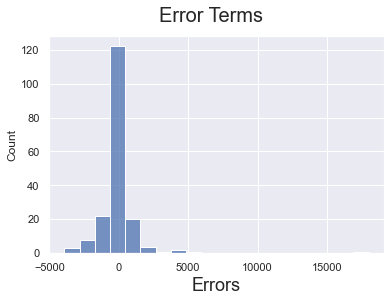

In [1745]:
y_followers = lm.predict(X_rfe)

# Plot the histogram of the error terms
fig = plt.figure(figsize=(6,4))
sns.histplot((y - y_followers), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18);                        # X-label

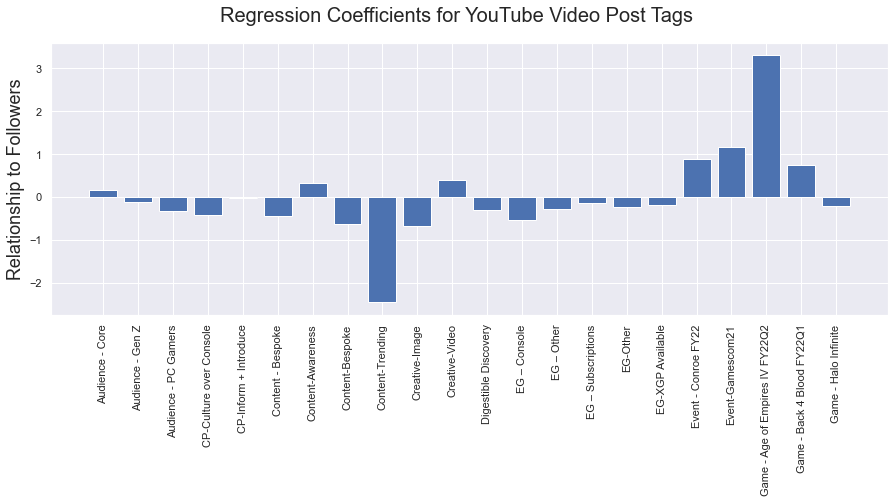

In [1746]:
scaler = StandardScaler()
scaled = scaler.fit_transform([[x] for x in lm.params[1:]])
scaled = [x for lst in scaled for x in lst]

fig = plt.figure(figsize=(15, 5))
plt.bar(x=lm.params[1:].index,height=scaled)
plt.xticks(rotation=90)
fig.suptitle('Regression Coefficients for YouTube Video Post Tags', fontsize=20)
plt.ylabel("Relationship to Followers", fontsize=18);                  # Plot heading

In [1747]:
sheet = "youtube"
with pd.ExcelWriter('output.xlsx',
                    mode='a',if_sheet_exists='replace') as writer:  
    lm.params.rename("coef").to_excel(writer, sheet_name=sheet)
    pd.DataFrame(scaled, index=lm.params.index[1:], columns=["coef"]).to_excel(writer, sheet_name=f"{sheet} scaled")